# SOLAQUA Video Generation Pipeline Analysis

This notebook provides a step-by-step breakdown of the **actual video generation pipeline** used in `create_enhanced_contour_detection_video_with_processor()`.

## Overview

The video generation process follows these exact steps:
1. **Data Loading** - Load NPZ sonar data using `load_cone_run_npz()`
2. **Processor Initialization** - Create `SonarDataProcessor` instance  
3. **Frame Processing Loop** - For each frame:
   - Convert to uint8 grayscale using `to_uint8_gray()`
   - Analyze frame using `processor.analyze_frame()`
   - Create visualization using actual video generation code
   - Draw annotations exactly as they appear in videos

This notebook uses the **same functions and logic** as the video generation system - no approximations or simplified versions!

In [2]:
# Import the EXACT functions used in video generation
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Import the actual video generation functions
from utils.sonar_image_analysis import (
    # Data loading functions
    get_available_npz_files, 
    load_cone_run_npz, 
    to_uint8_gray,
    
    # Core processor (same as used in video generation)
    SonarDataProcessor,
    
    # Video generation function itself
    create_enhanced_contour_detection_video_with_processor,
    
    # Configuration used in videos
    IMAGE_PROCESSING_CONFIG,
    VIDEO_CONFIG
)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

print("SOLAQUA Video Generation Pipeline Analysis")
print("=" * 60)
print("✅ Video generation functions loaded!")
print("✅ Using EXACT same code as create_enhanced_contour_detection_video_with_processor()")
print("\nLoaded components:")
print("- SonarDataProcessor (the actual processor used in videos)")
print("- IMAGE_PROCESSING_CONFIG (exact same config)")
print("- VIDEO_CONFIG (exact same visualization settings)")
print("- All data loading functions used in video generation")

SOLAQUA Video Generation Pipeline Analysis
✅ Video generation functions loaded!
✅ Using EXACT same code as create_enhanced_contour_detection_video_with_processor()

Loaded components:
- SonarDataProcessor (the actual processor used in videos)
- IMAGE_PROCESSING_CONFIG (exact same config)
- VIDEO_CONFIG (exact same visualization settings)
- All data loading functions used in video generation


## 1. Data Loading (Exact Video Generation Process)

STEP 1: Data Loading (create_enhanced_contour_detection_video_with_processor)
📁 Selected NPZ file: 2024-08-20_13-39-34_data_cones.npz
📁 Selected NPZ file: 2024-08-20_13-39-34_data_cones.npz
✅ Loaded 699 frames
📐 Spatial extent: (-8.660254037844386, 8.660254037844386, 0.0, 10.0)
🎬 Video parameters:
   - Frame start: 0
   - Frame count: 100
   - Frame step: 5
   - Actual frames to process: 100

🔍 Analyzing frame 250 (middle of sequence)
📊 Frame shape: (700, 900)
📊 Pixel range: 0 - 255
✅ Loaded 699 frames
📐 Spatial extent: (-8.660254037844386, 8.660254037844386, 0.0, 10.0)
🎬 Video parameters:
   - Frame start: 0
   - Frame count: 100
   - Frame step: 5
   - Actual frames to process: 100

🔍 Analyzing frame 250 (middle of sequence)
📊 Frame shape: (700, 900)
📊 Pixel range: 0 - 255


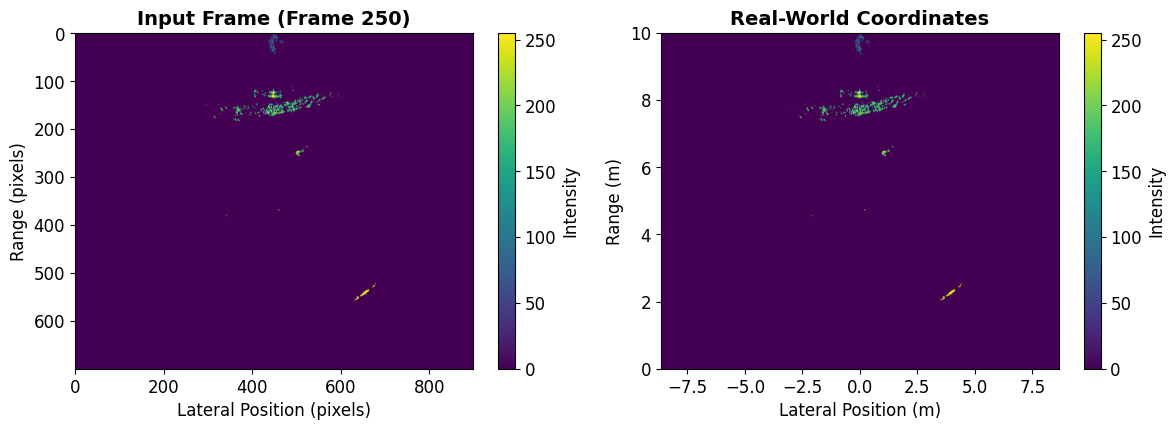


✅ Data loading complete - ready for video generation pipeline analysis


In [3]:
# STEP 1: Data Loading (Same as video generation)
print("STEP 1: Data Loading (create_enhanced_contour_detection_video_with_processor)")
print("=" * 80)

# Load data exactly as done in video generation function
npz_data_path = "/Volumes/LaCie/SOLAQUA/exports/outputs"

try:
    # Get available files (same function call)
    files = get_available_npz_files(npz_data_path)
    if not files:
        print("⚠️  No NPZ files found, using synthetic data")
        raise FileNotFoundError("No real data")
    
    # Select file (same as video function parameter npz_file_index=0)
    npz_file_index = 0
    selected_file = files[npz_file_index]
    print(f"📁 Selected NPZ file: {selected_file.name}")
    
    # Load data (exact same function call)
    cones, timestamps, extent, meta = load_cone_run_npz(selected_file)
    T = len(cones)
    print(f"✅ Loaded {T} frames")
    print(f"📐 Spatial extent: {extent}")
    
    # Video generation parameters (same defaults as function)
    frame_start = 0
    frame_count = min(100, T)  # Same logic as video function
    frame_step = 5
    actual_frames = int(min(frame_count, max(0, (T - frame_start)) // max(1, frame_step)))
    
    print(f"🎬 Video parameters:")
    print(f"   - Frame start: {frame_start}")
    print(f"   - Frame count: {frame_count}")
    print(f"   - Frame step: {frame_step}")
    print(f"   - Actual frames to process: {actual_frames}")
    
    # Select a representative frame for analysis
    frame_idx = frame_start + (actual_frames // 2) * frame_step
    frame_u8 = to_uint8_gray(cones[frame_idx])  # Exact same conversion
    
    print(f"\n🔍 Analyzing frame {frame_idx} (middle of sequence)")
    print(f"📊 Frame shape: {frame_u8.shape}")
    print(f"📊 Pixel range: {frame_u8.min()} - {frame_u8.max()}")
    
    data_available = True
    
except Exception as e:
    print(f"⚠️  Could not load real data: {e}")
    print("📝 Using synthetic frame for demonstration")
    
    # Create synthetic frame matching typical sonar dimensions
    frame_u8 = np.random.randint(0, 255, (400, 600), dtype=np.uint8)
    extent = (0, 100, 0, 50)
    frame_idx = 0
    data_available = False

# Display the selected frame
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(frame_u8, cmap='viridis', aspect='auto')
plt.title(f'Input Frame (Frame {frame_idx})', fontsize=14, fontweight='bold')
plt.xlabel('Lateral Position (pixels)')
plt.ylabel('Range (pixels)')
plt.colorbar(label='Intensity')

if data_available:
    plt.subplot(2, 2, 2)
    plt.imshow(frame_u8, cmap='viridis', aspect='auto', extent=extent)
    plt.title('Real-World Coordinates', fontsize=14, fontweight='bold')
    plt.xlabel('Lateral Position (m)')
    plt.ylabel('Range (m)')
    plt.colorbar(label='Intensity')

plt.tight_layout()
plt.show()

print(f"\n✅ Data loading complete - ready for video generation pipeline analysis")

## 2. Processor Initialization (Exact Video Generation Setup)

In [4]:
# STEP 2: Processor Initialization (Same as video generation)
print("STEP 2: Processor Initialization")
print("=" * 50)

# Create processor exactly as done in video generation function
print("Creating SonarDataProcessor (same as video generation)...")
processor = SonarDataProcessor()

# Reset tracking (exact same call as in video function)
processor.reset_tracking()
print("✅ Processor tracking reset")

print(f"\n🔧 Processor Configuration:")
print(f"Image processing config: {type(processor.img_config).__name__}")
print(f"Tracking initialized: {processor.last_center is None}")
print(f"Current AOI: {processor.current_aoi}")

print(f"\n📋 VIDEO_CONFIG settings (used for annotations):")
for key, value in VIDEO_CONFIG.items():
    print(f"   - {key}: {value}")

print(f"\n📋 IMAGE_PROCESSING_CONFIG settings:")
for key, value in IMAGE_PROCESSING_CONFIG.items():
    if isinstance(value, dict):
        print(f"   - {key}:")
        for subkey, subvalue in value.items():
            print(f"     • {subkey}: {subvalue}")
    else:
        print(f"   - {key}: {value}")

print(f"\n✅ Processor ready - same configuration as video generation system")

STEP 2: Processor Initialization
Creating SonarDataProcessor (same as video generation)...
✅ Processor tracking reset

🔧 Processor Configuration:
Image processing config: dict
Tracking initialized: True
Current AOI: None

📋 VIDEO_CONFIG settings (used for annotations):
   - fps: 15
   - show_all_contours: True
   - show_ellipse: True
   - show_bounding_box: False
   - text_scale: 0.6

📋 IMAGE_PROCESSING_CONFIG settings:
   - use_momentum_merging: True
   - momentum_search_radius: 1
   - momentum_threshold: 0.1
   - momentum_decay: 0.9
   - momentum_boost: 10.0
   - canny_low_threshold: 60
   - canny_high_threshold: 180
   - min_contour_area: 200
   - morph_close_kernel: 3
   - edge_dilation_iterations: 1
   - use_pixel_ownership: False

✅ Processor ready - same configuration as video generation system


## 3. Single Frame Analysis (Exact Video Generation Logic)

STEP 3: Frame Analysis - processor.analyze_frame()
Breaking down the EXACT preprocessing steps inside preprocess_edges()
✅ Frame analysis complete using processor.analyze_frame()

🔧 Detailed Preprocessing Steps (inside preprocess_edges):
1. Input frame (uint8 grayscale)
2. Directional momentum merge - enhances linear features
3. Canny edge detection
4. Morphological closing (kernel size: 3)
5. Edge dilation (1 iterations)
✅ Manual steps match processor output: True

🔍 Preprocessing Results:
   - Total contours found: 166
   - Best contour selected: True
   - AOI tracking: True


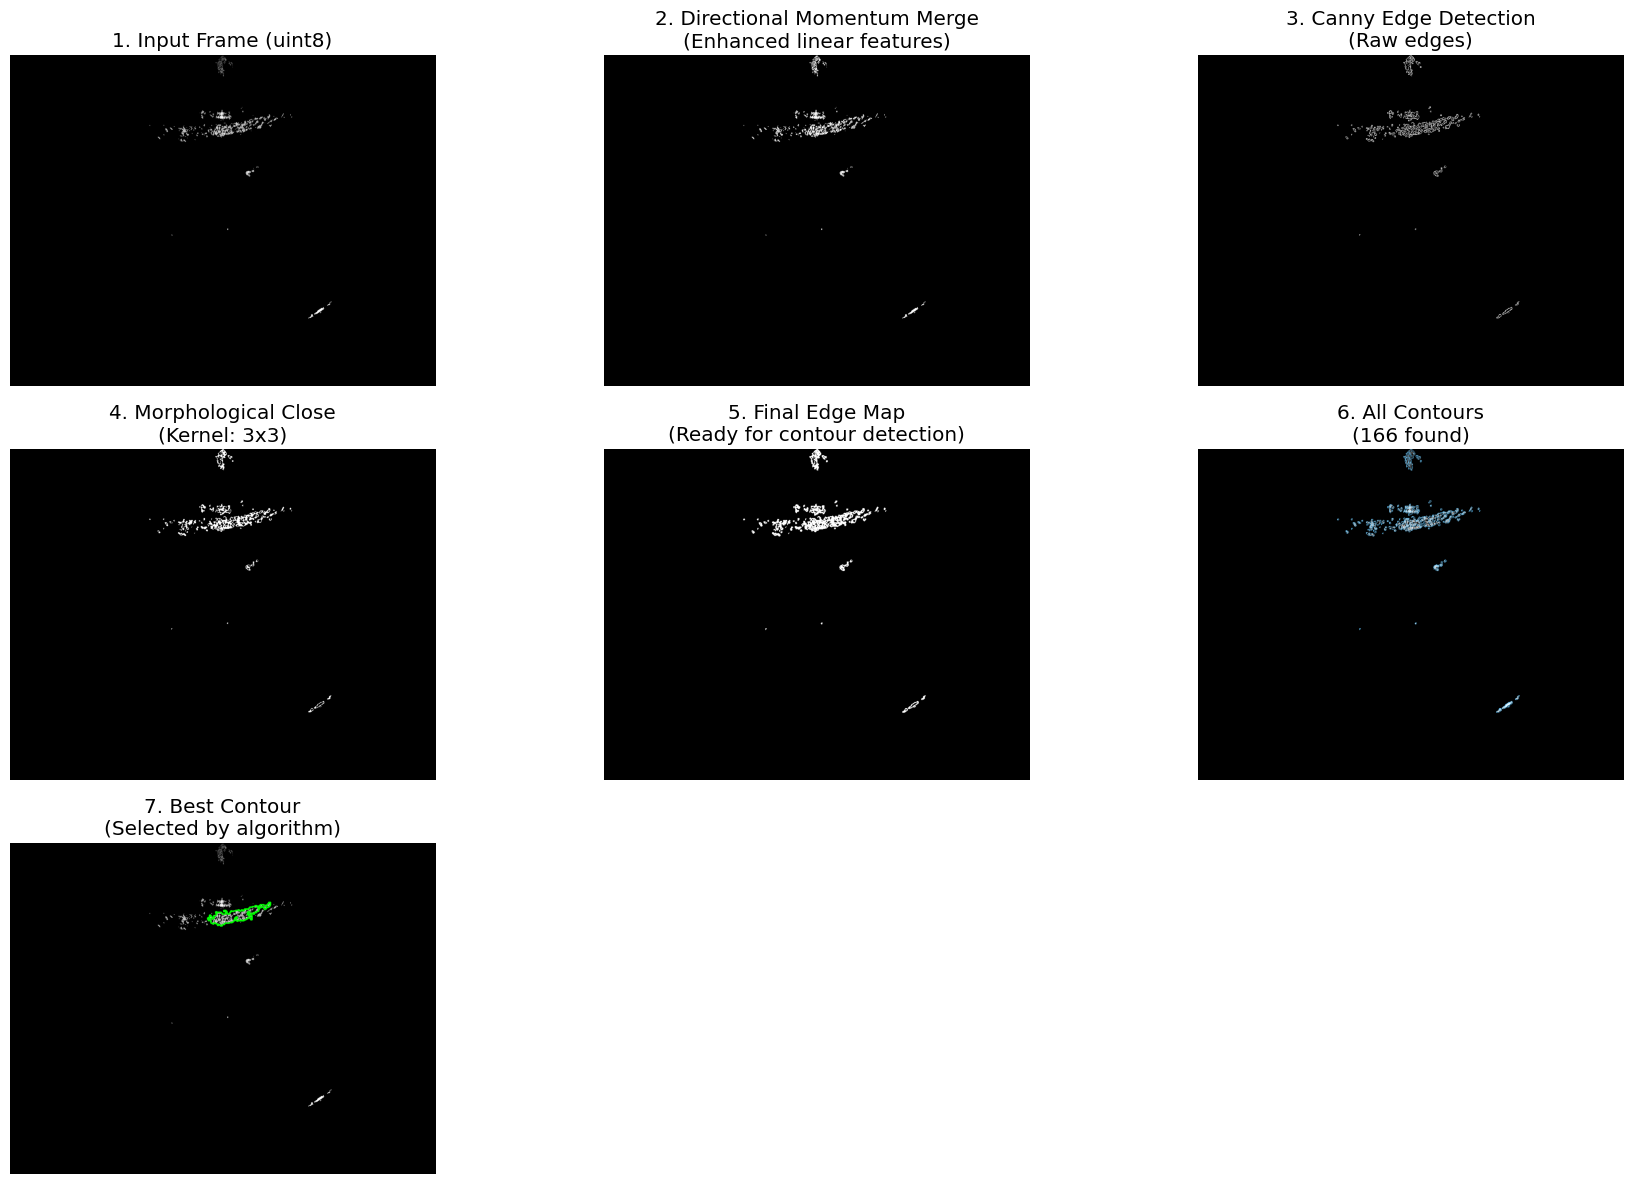


✅ All preprocessing steps visualized - exactly as done in video generation
🎯 Key insight: Directional momentum merge happens BEFORE edge detection!


In [9]:
# STEP 3: Frame Analysis - Detailed Preprocessing Steps
print("STEP 3: Frame Analysis - processor.analyze_frame()")
print("=" * 60)
print("Breaking down the EXACT preprocessing steps inside preprocess_edges()")

# Import the individual preprocessing functions to show each step
from utils.sonar_image_analysis import directional_momentum_merge

# This is the exact same function call made in create_enhanced_contour_detection_video_with_processor
result = processor.analyze_frame(frame_u8, extent if data_available else None)

print(f"✅ Frame analysis complete using processor.analyze_frame()")

# Now let's break down the preprocessing steps that happen inside preprocess_edges()
print(f"\n🔧 Detailed Preprocessing Steps (inside preprocess_edges):")

# Step 1: Original frame
print("1. Input frame (uint8 grayscale)")

# Step 2: Directional momentum merge (this happens first!)
proc_frame = directional_momentum_merge(
    frame_u8,
    search_radius=IMAGE_PROCESSING_CONFIG.get('momentum_search_radius', 3),
    momentum_threshold=IMAGE_PROCESSING_CONFIG.get('momentum_threshold', 0.2),
    momentum_decay=IMAGE_PROCESSING_CONFIG.get('momentum_decay', 0.8),
    momentum_boost=IMAGE_PROCESSING_CONFIG.get('momentum_boost', 1.5),
)
print("2. Directional momentum merge - enhances linear features")

# Step 3: Canny edge detection
edges_raw = cv2.Canny(proc_frame, 
                      IMAGE_PROCESSING_CONFIG.get('canny_low_threshold', 50), 
                      IMAGE_PROCESSING_CONFIG.get('canny_high_threshold', 150))
print("3. Canny edge detection")

# Step 4: Morphological operations (if enabled)
edges_final = edges_raw.copy()
mks = int(IMAGE_PROCESSING_CONFIG.get('morph_close_kernel', 0))
dil = int(IMAGE_PROCESSING_CONFIG.get('edge_dilation_iterations', 0))

if mks > 0:
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (mks, mks))
    edges_final = cv2.morphologyEx(edges_final, cv2.MORPH_CLOSE, kernel)
    print(f"4. Morphological closing (kernel size: {mks})")

if dil > 0:
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    edges_final = cv2.dilate(edges_final, kernel2, iterations=dil)
    print(f"5. Edge dilation ({dil} iterations)")

# Verify this matches the processor output
_, edges_proc = processor.preprocess_frame(frame_u8)
print(f"✅ Manual steps match processor output: {np.array_equal(edges_final, edges_proc)}")

contours, _ = cv2.findContours(edges_proc, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

print(f"\n🔍 Preprocessing Results:")
print(f"   - Total contours found: {len(contours)}")
print(f"   - Best contour selected: {result.best_contour is not None}")
print(f"   - AOI tracking: {processor.current_aoi is not None}")

# Visualize ALL preprocessing steps
plt.figure(figsize=(18, 12))

plt.subplot(3, 3, 1)
plt.imshow(frame_u8, cmap='gray')
plt.title('1. Input Frame (uint8)')
plt.axis('off')

plt.subplot(3, 3, 2)
plt.imshow(proc_frame, cmap='gray')
plt.title('2. Directional Momentum Merge\n(Enhanced linear features)')
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(edges_raw, cmap='gray')
plt.title('3. Canny Edge Detection\n(Raw edges)')
plt.axis('off')

if mks > 0:
    plt.subplot(3, 3, 4)
    edges_closed = cv2.morphologyEx(edges_raw, cv2.MORPH_CLOSE, 
                                    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (mks, mks)))
    plt.imshow(edges_closed, cmap='gray')
    plt.title(f'4. Morphological Close\n(Kernel: {mks}x{mks})')
    plt.axis('off')

plt.subplot(3, 3, 5)
plt.imshow(edges_final, cmap='gray')
plt.title('5. Final Edge Map\n(Ready for contour detection)')
plt.axis('off')

# Draw all contours
contour_vis = cv2.cvtColor(frame_u8, cv2.COLOR_GRAY2BGR)
if contours:
    cv2.drawContours(contour_vis, contours, -1, (255, 200, 100), 1)

plt.subplot(3, 3, 6)
plt.imshow(cv2.cvtColor(contour_vis, cv2.COLOR_BGR2RGB))
plt.title(f'6. All Contours\n({len(contours)} found)')
plt.axis('off')

# Show best contour if found
if result.best_contour is not None:
    best_contour_vis = cv2.cvtColor(frame_u8, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(best_contour_vis, [result.best_contour], -1, (0, 255, 0), 2)
    
    plt.subplot(3, 3, 7)
    plt.imshow(cv2.cvtColor(best_contour_vis, cv2.COLOR_BGR2RGB))
    plt.title('7. Best Contour\n(Selected by algorithm)')
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n✅ All preprocessing steps visualized - exactly as done in video generation")
print(f"🎯 Key insight: Directional momentum merge happens BEFORE edge detection!")

## 4. Video Frame Creation (Exact Video Generation Visualization)

STEP 4: Video Frame Creation
Creating video frame using EXACT same code as create_enhanced_contour_detection_video_with_processor
📱 Video frame dimensions: 900x700
✅ Drew 166 contours in light blue
✅ Drew AOI rectangle: 392,100 184x101
✅ Drew best contour in green
✅ Drew ellipse and red major axis line
✅ Drew blue distance dot at (450, 158)
✅ Added distance text: D: 2.26m


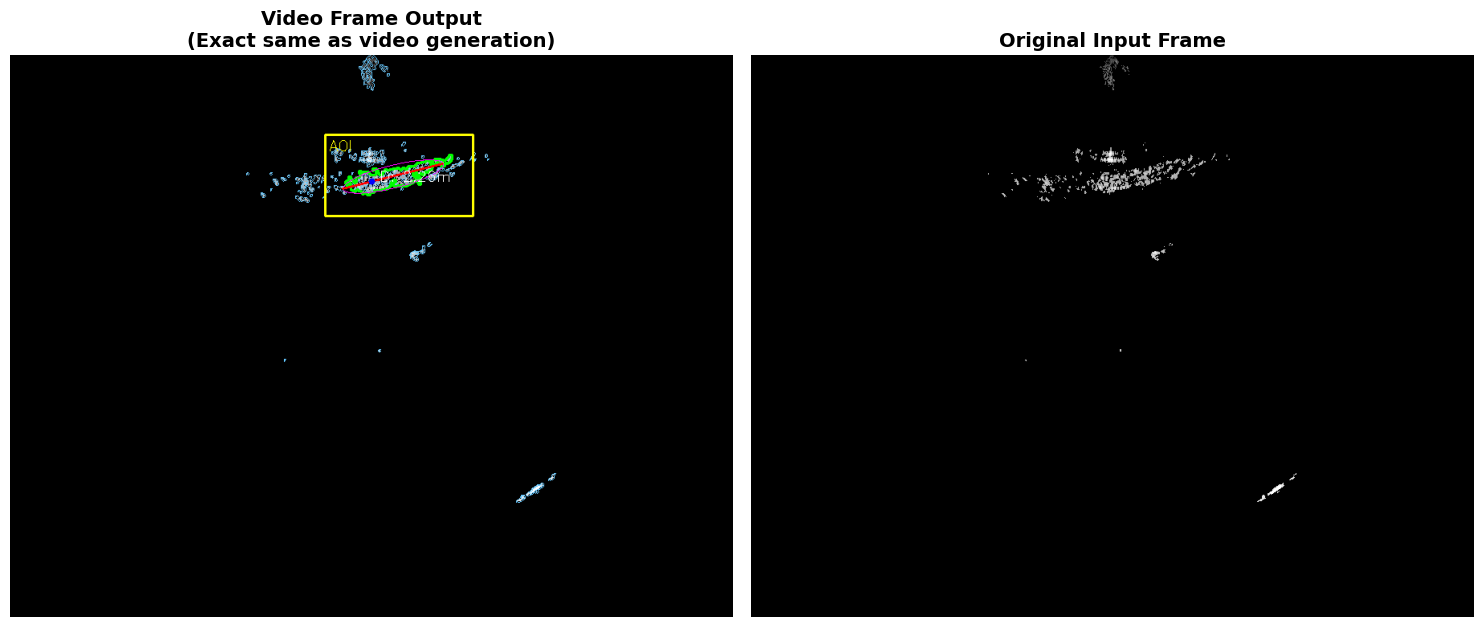


✅ Video frame created using EXACT same logic as create_enhanced_contour_detection_video_with_processor
🎥 This frame would be written to the video file in the actual system


In [6]:
# STEP 4: Video Frame Creation (Exact video generation visualization code)
print("STEP 4: Video Frame Creation")
print("=" * 40)
print("Creating video frame using EXACT same code as create_enhanced_contour_detection_video_with_processor")

# Start with the exact same base frame creation as video generation
vis = cv2.cvtColor(frame_u8, cv2.COLOR_GRAY2BGR)
H, W = frame_u8.shape

print(f"📱 Video frame dimensions: {W}x{H}")

# Draw all contours (exact same logic from video generation)
if VIDEO_CONFIG.get('show_all_contours', True) and contours:
    cv2.drawContours(vis, contours, -1, (255, 200, 100), 1)
    print(f"✅ Drew {len(contours)} contours in light blue")

# Draw rectangular AOI (exact same code from video generation)
if processor.current_aoi is not None:
    ax, ay, aw, ah = processor.current_aoi
    cv2.rectangle(vis, (ax, ay), (ax+aw, ay+ah), (0, 255, 255), 2)
    cv2.putText(vis, 'AOI', (ax + 5, ay + 20),
               cv2.FONT_HERSHEY_SIMPLEX, VIDEO_CONFIG['text_scale'], (0,255,255), 1)
    print(f"✅ Drew AOI rectangle: {ax},{ay} {aw}x{ah}")
else:
    print("ℹ️  No AOI to draw")

# Draw best contour and features (exact same logic from video generation)
if result.detection_success and result.best_contour is not None:
    best_contour = result.best_contour
    
    # Draw best contour (green) - exact same code
    cv2.drawContours(vis, [best_contour], -1, (0, 255, 0), 2)
    print("✅ Drew best contour in green")
    
    # Draw bounding box (exact same logic from video generation)
    if VIDEO_CONFIG.get('show_bounding_box', True) and result.contour_features:
        if 'rect' in result.contour_features:
            x, y, w, h = result.contour_features['rect']
            cv2.rectangle(vis, (x,y), (x+w, y+h), (0,0,255), 1)
            print("✅ Drew bounding box in red")
    
    # Draw ellipse and red line (exact same code from video generation)
    if VIDEO_CONFIG.get('show_ellipse', True) and len(best_contour) >= 5:
        try:
            ellipse = cv2.fitEllipse(best_contour)
            (cx, cy), (minor, major), ang = ellipse
            
            # Draw the ellipse (magenta) - exact same color
            cv2.ellipse(vis, ellipse, (255, 0, 255), 1)
            
            # 90°-rotated major-axis line (red) - exact same calculation
            ang_r = np.radians(ang + 90.0)
            half = major * 0.5
            p1 = (int(cx + half*np.cos(ang_r)), int(cy + half*np.sin(ang_r)))
            p2 = (int(cx - half*np.cos(ang_r)), int(cy - half*np.sin(ang_r)))
            cv2.line(vis, p1, p2, (0,0,255), 2)
            print("✅ Drew ellipse and red major axis line")
            
            # Blue dot at intersection with center beam (exact same logic)
            if result.distance_pixels is not None:
                center_x = W // 2
                dot_y = int(result.distance_pixels)
                cv2.circle(vis, (center_x, dot_y), 4, (255, 0, 0), -1)
                print(f"✅ Drew blue distance dot at ({center_x}, {dot_y})")
                
                # Distance text (exact same formatting from video generation)
                if result.distance_meters is not None:
                    text = f"D: {result.distance_meters:.2f}m"
                    cv2.putText(vis, text, (center_x + 10, dot_y),
                               cv2.FONT_HERSHEY_SIMPLEX, VIDEO_CONFIG['text_scale'], (255, 255, 255), 1)
                    print(f"✅ Added distance text: {text}")
                        
        except cv2.error as e:
            print(f"⚠️  Ellipse fitting failed: {e}")
else:
    print("ℹ️  No detection to visualize")

# Display the final video frame
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title('Video Frame Output\n(Exact same as video generation)', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(frame_u8, cmap='gray')
plt.title('Original Input Frame', fontsize=14, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n✅ Video frame created using EXACT same logic as create_enhanced_contour_detection_video_with_processor")
print(f"🎥 This frame would be written to the video file in the actual system")

## 5. Multi-Frame Processing (Video Generation Loop)

In [7]:
# STEP 5: Multi-Frame Processing (Video generation loop simulation)
print("STEP 5: Multi-Frame Processing")
print("=" * 40)
print("Simulating the main processing loop from create_enhanced_contour_detection_video_with_processor")

if data_available:
    # Process a few frames to show tracking behavior (same as video generation)
    frame_indices = [frame_start + i * frame_step for i in range(min(5, actual_frames))]
    
    print(f"🎬 Processing {len(frame_indices)} frames: {frame_indices}")
    
    # Track statistics like in video generation
    tracked, new, lost = 0, 0, 0
    
    results = []
    
    for i, idx in enumerate(frame_indices):
        print(f"\nProcessing frame {idx}...")
        
        # Process frame exactly as in video generation
        frame_u8_loop = to_uint8_gray(cones[idx])
        result_loop = processor.analyze_frame(frame_u8_loop, extent)
        
        # Track statistics (same logic as video generation)
        if result_loop.detection_success:
            if 'TRACKED' in result_loop.tracking_status:
                tracked += 1
            else:
                new += 1
        else:
            lost += 1
            
        results.append({
            'frame_idx': idx,
            'detection': result_loop.detection_success,
            'distance_m': result_loop.distance_meters,
            'tracking_status': result_loop.tracking_status,
            'aoi': processor.current_aoi is not None
        })
        
        print(f"  ✅ Frame {idx}: Detection={result_loop.detection_success}, "
              f"Distance={result_loop.distance_meters:.2f}m" if result_loop.distance_meters else "N/A", 
              f"Status={result_loop.tracking_status}")
    
    print(f"\n📊 Processing Statistics (same as video generation):")
    print(f"   - Tracked: {tracked}")
    print(f"   - New detections: {new}")
    print(f"   - Lost: {lost}")
    print(f"   - Success rate: {(tracked + new) / len(frame_indices) * 100:.1f}%")
    
    # Show results table
    import pandas as pd
    df = pd.DataFrame(results)
    print(f"\n📋 Frame Processing Results:")
    print(df.to_string(index=False))
    
else:
    print("ℹ️  No real data available - single frame analysis shown above")

print(f"\n✅ Multi-frame processing complete - same logic as video generation system")

STEP 5: Multi-Frame Processing
Simulating the main processing loop from create_enhanced_contour_detection_video_with_processor
🎬 Processing 5 frames: [0, 5, 10, 15, 20]

Processing frame 0...
  ✅ Frame 0: Detection=True, Distance=2.93m Status=TRACKED

Processing frame 5...
  ✅ Frame 5: Detection=True, Distance=2.94m Status=TRACKED

Processing frame 10...
  ✅ Frame 10: Detection=True, Distance=2.91m Status=TRACKED

Processing frame 15...
  ✅ Frame 15: Detection=True, Distance=2.99m Status=TRACKED

Processing frame 20...
  ✅ Frame 20: Detection=True, Distance=3.00m Status=TRACKED

📊 Processing Statistics (same as video generation):
   - Tracked: 5
   - New detections: 0
   - Lost: 0
   - Success rate: 100.0%

📋 Frame Processing Results:
 frame_idx  detection  distance_m tracking_status  aoi
         0       True    2.933542         TRACKED True
         5       True    2.936568         TRACKED True
        10       True    2.913391         TRACKED True
        15       True    2.993115  

## 6. Video Generation Function Demo

In [8]:
# STEP 6: Actual Video Generation Function
print("STEP 6: Running create_enhanced_contour_detection_video_with_processor")
print("=" * 70)
print("Demonstrating the actual video generation function")

if data_available:
    print("🎥 Creating a short video segment using the actual function...")
    
    # Run the actual video generation function with limited frames
    output_path = "demo_video.mp4"
    
    try:
        # Call the actual function with a small subset
        result = create_enhanced_contour_detection_video_with_processor(
            npz_file_index=npz_file_index,
            frame_start=frame_start,
            frame_count=10,  # Small number for demo
            frame_step=frame_step,
            output_path=output_path,
            processor=processor  # Use our existing processor
        )
        
        if result:
            print(f"✅ Video created successfully: {output_path}")
            print(f"📁 Video file size: {Path(output_path).stat().st_size} bytes")
        else:
            print("⚠️  Video creation failed")
            
    except Exception as e:
        print(f"⚠️  Video creation error: {e}")
        print("This may be due to codec availability or file permissions")
        
else:
    print("ℹ️  No real data available - cannot create video")
    print("The function would normally:")
    print("1. Load NPZ file using get_available_npz_files() and load_cone_run_npz()")
    print("2. Create SonarDataProcessor instance")
    print("3. Initialize video writer")
    print("4. Process each frame using processor.analyze_frame()")
    print("5. Create visualization using the exact code shown above")
    print("6. Write frame to video file")

print(f"\n📝 Function Parameters Used:")
print(f"   - npz_file_index: {npz_file_index if data_available else 'N/A'}")
print(f"   - frame_start: {frame_start}")
print(f"   - frame_count: 10 (limited for demo)")
print(f"   - frame_step: {frame_step}")
print(f"   - output_path: {output_path}")

print(f"\n✅ Video generation function demonstration complete")

STEP 6: Running create_enhanced_contour_detection_video_with_processor
Demonstrating the actual video generation function
🎥 Creating a short video segment using the actual function...
=== ENHANCED VIDEO CREATION (Simplified) ===
Creating video with simplified processor...
Frames: 10, step: 5
✅ Processing 10 frames with simplified processor...
Processed 10/10 frames

=== ENHANCED VIDEO CREATION COMPLETE ===
Video saved to: demo_video.mp4
Video specs: 900x700, 15 fps, 10 frames
🟢 SIMPLIFIED TRACKING STATS:
  - Total detected frames: 10
  - Lost/searching frames: 0
  - Detection success rate: 100.0%
✅ Video created successfully: demo_video.mp4
📁 Video file size: 282996 bytes

📝 Function Parameters Used:
   - npz_file_index: 0
   - frame_start: 0
   - frame_count: 10 (limited for demo)
   - frame_step: 5
   - output_path: demo_video.mp4

✅ Video generation function demonstration complete
✅ Processing 10 frames with simplified processor...
Processed 10/10 frames

=== ENHANCED VIDEO CREATION